# The METIS-WCU mode in Scopesim

This notebook documents the implementation of the METIS WCU in `Scopesim`. It is largely a stand-alone effect that requires no further `Source` object. In addition to the normal "sky" modes there are new wcu modes that combine the WCU with the existing subsystems of METIS. Currently, these are
- `wcu_img_lm`
- `wcu_img_n`
- `wcu_lss_l`
- `wcu_lss_m`
- `wcu_lss_n`
- `wcu_lms`

The most basic way to run this mode is as follows
```python
import scopesim as sim
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["wcu_lss_m"])
metis = sim.OpticalTrain(cmd)
metis.observe()
hdul = metis.readout()[0]
```
However, this sequence will saturate the detector and currently (2025-03-10) throw an error during readout (a header mismatch due to the lack of telescope information). In the following we will go through the sequence and show how to change parameters to get a satisfactory result. We will use `wcu_img_lm` for that purpose.

## Setting up the `OpticalTrain`

In [1]:
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt

In [2]:
import scopesim as sim

# Edit this path if you have a custom install directory, otherwise comment it out. [For ReadTheDocs only]
sim.link_irdb("../../../")

In [3]:
#sim.download_packages(["METIS"])

In [4]:
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["wcu_img_lm"])

In [5]:
metis = sim.OpticalTrain(cmd)

Let's have look at the effects that are included in the `OpticalTrain`: 

In [6]:
metis.effects.pprint_all()

    element                  name                       class             included
---------------- --------------------------- ---------------------------- --------
       METIS_WCU                  wcu_source                    WCUSource     True
       METIS_WCU            wcu_relay_optics                  SurfaceList     True
       METIS_WCU        pupil_masks : [open]               PupilMaskWheel     True
       METIS_WCU           wcu_fits_keywords            ExtraFitsKeywords     True
           METIS          common_fore_optics                  SurfaceList     True
           METIS         adc_wheel : [False]                     ADCWheel    False
           METIS        slit_wheel : [False]                    SlitWheel    False
           METIS                   cold_stop            PupilTransmission     True
           METIS        common_fits_keywords            ExtraFitsKeywords     True
           METIS           cfo_fits_keywords            ExtraFitsKeywords     True
    

There are three effects associated with the WCU; these replace the atmosphere and telescope effects that are used in the sky modes. `wcu_relay_optics` is a static effect that describes the mirrors within the WCU and does not need to be modified by most users. `pupil_masks` is used to select a pupil mask; in the full implementation this will affect the PSF, but currently only a flux throughput factor is implemented. We will ignore this effect for the time being.
The interesting effect with many user-settable parameters is `wcu_source`. For convenience we will assign a variable to reference it, but all operations below could be done directly to `metis['wcu_source']`. 

In [7]:
wcu = metis['wcu_source']

An overview of the setup of the WCU can be obtained with

In [8]:
print(wcu)

WCUSource: "wcu_source"
Current lamp:            bb     ['bb', 'laser', 'none']
BlackBody temperature:   1000.0 K
Integrating sphere temp: 300.0 K
WCU temperature:         300.0 K
BlackBody aperture:      1.0
Focal-plane mask:        open  ['open', 'pinhole_lm', 'pinhole_n', 'grid_lm']



As can be seen, the default configuration uses the black-body continuum lamp at a temperature of 1000 Kelvin, with the flux-controlling mask ("BlackBody aperture") fully open. No focal-plane mask is inserted, which means that we are observing a flat field. The thermal backgrounds from the integrating sphere and the WCU itself are both set at a temperature of 300 Kelvin, so rather warm compared to typical atmospheric temperatures.
No `Source` is required (unlike for most sky observations) and we can create the (noise-less) image plane just ahead of the detector with

In [9]:
metis.observe()

astar.scopesim.optics.optical_train - Observing empty field


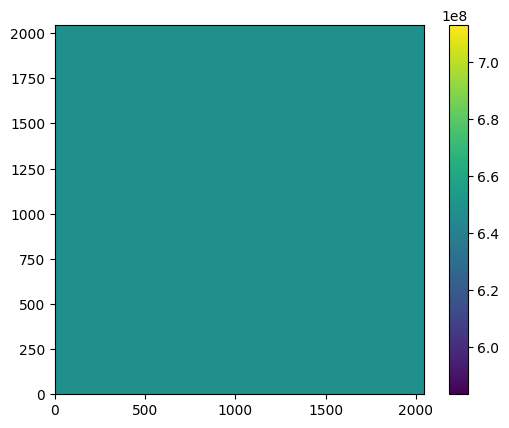

In [10]:
fig, ax = plt.subplots()
img = ax.imshow(metis.image_planes[0].data, origin="lower")
fig.colorbar(img);

As expected, no structure is seen in the `ImagePlane`. The expected photon flux per pixel is around 7.2e8 photons per second. This flux would saturate the Hawaii2RG detector of the LM imager within a minimum DIT (1.3 seconds in slow mode, 0.04 seconds in fast mode), so a neutral-density filter has to be inserted. Repeating the observation gives a manageable image-plane flux:

In [11]:
metis['nd_filter_wheel'].change_filter("ND_OD4")
metis.observe()
print(f"{metis.image_planes[0].data.mean():.2g}")

astar.scopesim.optics.optical_train - Observing empty field
6.5e+04


In [12]:
hdul = metis.readout(exptime=1.3)[0]

astar.scopesim.effects.electronic - Requested exposure time: 1.300 s
astar.scopesim.effects.electronic - Required DIT without saturation: 1.157 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.650 s, NDIT = 2
astar.scopesim.effects.electronic - Total exposure time: 1.300 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 4.0
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.650 s, NDIT = 2
astar.scopesim.effects.electronic - Total exposure time: 1.300 s


Mean:               10533.3
Standard deviation:    38.3


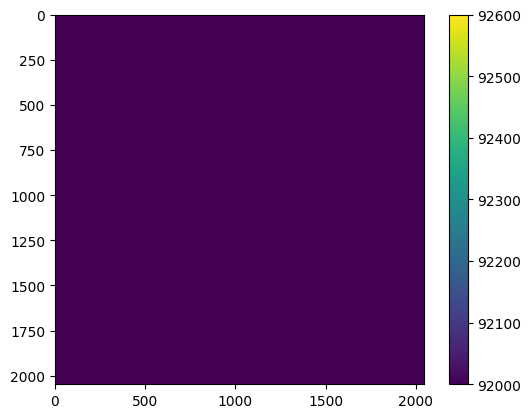

In [13]:
fig, ax = plt.subplots()
img = ax.imshow(hdul[1].data, vmin=92000, vmax=92600)
fig.colorbar(img)
print(f"Mean:               {hdul[1].data.mean():7.1f}")
print(f"Standard deviation: {hdul[1].data.std(): 7.1f}")

## Changing the black-body temperature

The method `.set_temperature` is used to set the temperature of the black-body source as well as the temperatures of the integrating sphere and the ambient temperature of the WCU. The latter two determine the thermal background, the former the actual signal that we want to record. In this illustrative example we remove the backgrounds and see how the temperature affects the signal level.

astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.optical_train - Observing empty field


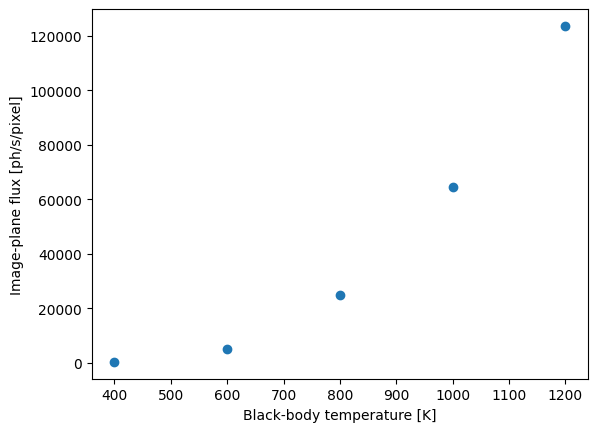

In [14]:
wcu.set_temperature(is_temp=0*u.K, wcu_temp=0*u.K)
temps = np.array([400, 600, 800, 1000, 1200]) * u.K
signal = np.zeros(5)
for i, temp in enumerate(temps):
    wcu.set_temperature(bb_temp=temp)
    metis.observe()
    signal[i] = metis.image_planes[0].data.mean()

_, ax = plt.subplots()
ax.plot(temps, signal, 'o')
ax.set_xlabel("Black-body temperature [K]")
ax.set_ylabel("Image-plane flux [ph/s/pixel]");

## Using the flux-controlling masks

The flux-controlling masks sit in front of the black-body source and control the flux that is entering the integrating sphere. These masks will be used for linearity measurements. It is currently not clear how the diameters of the masks translate to the amount of flux passed through. In the current implementation the method `.set_bb_aperture` accepts a number between 0 and 1 to describe directly the fraction of flux let through (values larger than 1 or less than 0 are clipped to 1 and 0, respectively).

astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.optics.optical_train - Observing empty field


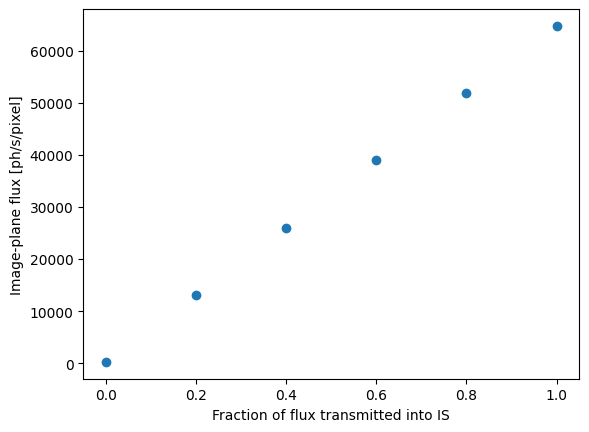

In [15]:
wcu.set_temperature(bb_temp=1000*u.K, is_temp=300*u.K, wcu_temp=300*u.K)
bb_ap = np.array([0., 0.2, 0.4, 0.6, 0.8, 1.])
signal = np.zeros(6)
for i, ap in enumerate(bb_ap):
    wcu.set_bb_aperture(ap)
    metis.observe()
    signal[i] = metis.image_planes[0].data.mean()

_, ax = plt.subplots()
ax.plot(bb_ap, signal, 'o')
ax.set_xlabel("Fraction of flux transmitted into IS")
ax.set_ylabel("Image-plane flux [ph/s/pixel]");

## Changing the focal-plane mask

So far, we have produced flat-field images with the 'open' focal-plane mask. The WCU has masks for a single pinhole and grids of pinholes. These can be applied using the `.set_fpmask` method. This method also allows to rotate and shift the mask (which in METIS would be done with the derotator and the internal chopper, respectively) and rotating the mask (which would be done with the derotator). 
Note that the design of the grid masks is not yet finished and the design used by Scopesim should be considered illustrative. 

Information on the currently inserted mask can be obtained with

In [16]:
print(wcu.fpmask)

FPMask: "open"
Angle:        0 deg
Shift:        [0, 0] arcsec



FPMask: "grid_lm"
Angle:        20 deg
Shift:        (1, 0.5) arcsec

astar.scopesim.optics.optical_train - Observing empty field


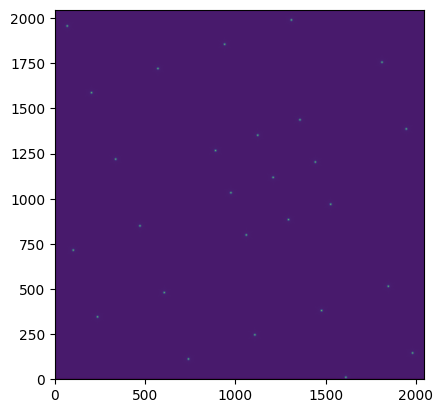

In [17]:
wcu.set_fpmask("grid_lm", angle=20, shift=(1, 0.5))
print(wcu.fpmask)
metis.observe()
_, ax = plt.subplots()
ax.imshow(metis.image_planes[0].data, norm="log", origin="lower");

In the example above, the name of a pre-defined mask was used (these are provided in the METIS instrument package as `wcu/fp_mask_*.dat`). To simplify testing of mask designs the method also accepts a valid path to a filename. To create your own mask start by copying one of the existing pinhole or grid masks and enter the hole positions in the `x` and `y` columns (in arcsec using a plate scale of 3.319 mm/arcsec) and hole diameter in the `diam` column (also in arcsec). Note that holes are currently assumed to be non-resolved and are modelled as a single pixel in a 2047 by 2047 image (`diam` scales the brightness of the flux passed through the hole).  

## Changing the lamp

In addition to the black-body source (`bb`),  the WCU includes three laser sources. As there is no observing mode that covers more than one of these lasers at a time, the implementation in Scopesim treats all three as a single `laser` lamp with lines in the L, M and N bands. The behaviour of the tunable laser in the M band is currently not clear and the implementation in Scopesim is not much more than a preliminary place holder. To change the lamp use the `.set_lamp` method:
```python
wcu.set_lamp('laser')
```

To show the behaviour we shall switch to the long-slit L-band mode with the grid mask and simulate spectra with both the black-body and the laser sources. To subtract the thermal background emission, we also take an exposure with the black-body source closed.

In [18]:
cmd = sim.UserCommands(use_instrument='METIS', set_modes=['wcu_lss_l'])
metis = sim.OpticalTrain(cmd)
wcu = metis['wcu_source']

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:163: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  fov = thetrace.fov_grid()

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()



In [19]:
wcu.set_fpmask('grid_lm')
print(wcu)
metis.observe()
implane_bb = metis.image_planes[0].data    # using bb source

WCUSource: "wcu_source"
Current lamp:            bb     ['bb', 'laser', 'none']
BlackBody temperature:   1000.0 K
Integrating sphere temp: 300.0 K
WCU temperature:         300.0 K
BlackBody aperture:      1.0
Focal-plane mask:        grid_lm  ['open', 'pinhole_lm', 'pinhole_n', 'grid_lm']

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()

astar.scopesim.optics.optical_train - Observing empty field


 FOV effects:   0%|          | 0/2 [00:00<?, ?it/s]

astar.scopesim.effects.psfs - Interpolating PSF onto (2600, 15, 512) cube


 PSF slices:   0%|          | 0/2600 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane - No BUNIT found in added HDU.


In [20]:
wcu.set_bb_aperture(0)
print(wcu)
metis.observe()
implane_off = metis.image_planes[0].data   # background, no source
wcu.set_bb_aperture(1)

WCUSource: "wcu_source"
Current lamp:            bb     ['bb', 'laser', None]
BlackBody temperature:   1000.0 K
Integrating sphere temp: 300.0 K
WCU temperature:         300.0 K
BlackBody aperture:      0
Focal-plane mask:        grid_lm  ['open', 'pinhole_lm', 'pinhole_n', 'grid_lm']

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()

astar.scopesim.optics.optical_train - Observing empty field


 FOV effects:   0%|          | 0/2 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane - No BUNIT found in added HDU.


In [21]:
wcu.set_lamp('laser')
print(wcu)
metis.observe()
implane_laser = metis.image_planes[0].data   # using laser source

WCUSource: "wcu_source"
Current lamp:            laser     ['bb', 'laser', None]
BlackBody temperature:   1000.0 K
Integrating sphere temp: 300.0 K
WCU temperature:         300.0 K
BlackBody aperture:      1
Focal-plane mask:        grid_lm  ['open', 'pinhole_lm', 'pinhole_n', 'grid_lm']

py.warnings - WARNING: /root/miniconda3/envs/scopesim/lib/python3.10/site-packages/scopesim/effects/spectral_trace_list.py:205: DeprecationWarning: The fov_grid method is deprecated and will be removed in a future release.
  vol = spt.fov_grid()

astar.scopesim.optics.optical_train - Observing empty field


 FOV effects:   0%|          | 0/2 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane - No BUNIT found in added HDU.


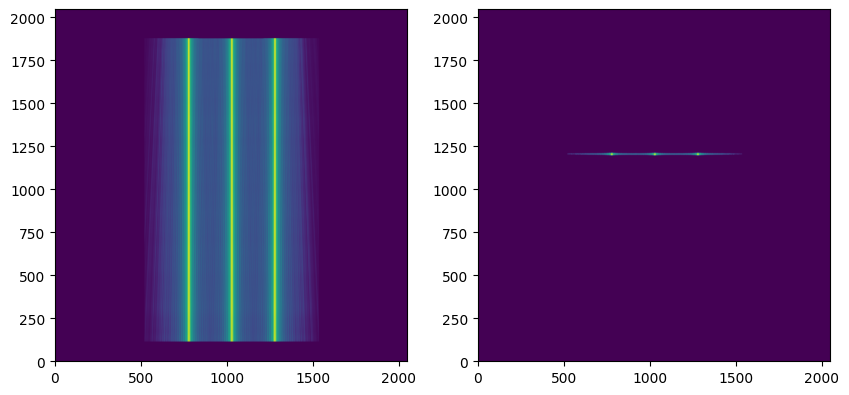

In [22]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(implane_bb - implane_off, origin="lower", norm="symlog")
ax1.imshow(implane_laser - implane_off, origin="lower", norm="symlog");

## Using a configuration file

The default configuration for the WCU is read from the file `metis_wcu_config.yaml` in the METIS instrument package. This is a yaml file that contains both the user-settable parameters described above and also physical quantities that describe the WCU itself:
```yaml
# ------------- User-settable parameters
lamps:  ["bb", "laser", "none"]  # available lamps
current_lamp: "bb"  # the lamp currently in use
bb_temp: 1000       # [K] temperature of BB source  # Kelvin!
is_temp:  300       # [K] temperature of the integratig sphere
wcu_temp: 300       # [K] ambient temperature in the WCU
bb_aperture: 1.0    # aperture of flux-controlling mask
fpmasks:  ["open", "pinhole_lm", "pinhole_n", "grid_lm"]
fpmask_filename_format: "wcu/fp_mask_{}.dat"
current_fpmask: "open"
fpmask_angle: 0
fpmask_shift: [0, 0]

# ------------- Data needed to describe the WCU
bb_to_is:     "wcu/WCU_BB_to_IS_throughput.fits"
is_reflect:   "wcu/WCU_IS_reflectivity.dat"
tube_reflect: "wcu/WCU_tube_reflectivity.dat"
mask_reflect: "wcu/WCU_mask_reflectivity.dat"
emiss_bb:      0.98     # E-REP-MPIA-MET-1203
diam_is_in:   25.4      # [mm] diameter of integrating sphere entrance port
diam_is:     250        # [mm] diameter of integrating sphere
diam_is_out: 100        # [mm] diameter if integrating sphere output port
rho_is:        0.95     # [] reflectivity of integrating sphere
rho_tube:      0.95     # [] reflectivity of tube between BB and IS
emiss_mask:    1.00     # [] emissivity of focal-plane mask
```
To use your own configuration file, copy the default file into your working directory and instantiate the `OpticalTrain` as follows:
```python
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["wcu_img_lm"])
cmd["!WCU.config_file") = "my_config.yaml"
metis = sim.OpticalTrain(cmd)
```

## Some shortcomings

- The gaps in the connection between the black-body source and the entrance port of the integrating sphere are not yet included (model is available in Roy van Boekel's document)
- The PSF defaults to the standard SCAO PSF included in the METIS instrument package. At the very least a PSF without atmosphere contribution should be available. Ideally the PSF should be tied to the pupil-plane mask (this also applies to sky observations).
- The focal-plane grid mask design is preliminary. The one included here has been taken from E-SPE-UZK-MET-1015 (v2), taking the Figure 5-6 as being to scale. It appears that this is not the case, though.
- Pupil imaging could maybe be included. This could be included as an additional focal-plane mask with the appropriate plate scale onto the detectors. There are some differences as to which optical elements are included in the optical train as compared to the normal modes, but these are presumably of secondary importance. 